# **Final Project**
### **SEP 6DA3: Data Analytics and Big Data**

**Presented By**

Kenil Sachapara (400551600)\
Om Kakadiya (400551508)\
Hem Gondaliya (400551597)

In [1]:
!pip install --upgrade opendatasets


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import os
from zipfile import ZipFile

import plotly.express as px

%matplotlib inline

# **1. Data Preparation**

The dataset contain the three files in the csv format:

**train.csv** : this file has 421570 rows and 5 columns. The columns contain the information for a store, department, date, weekly sales and whether a particular week is a holiday week or not

**store.csv** : this file has 45 rows and 3 columns. The columns correpond to the stores, their type and sizes of stores

**features.csv**: this file 8190 rows and 12 columns. This file again has some further information regarding the stores and the region in which a particular store is located. It has date, temperature, fuel price, consumer price index, unemployment rate information for the region in which a particular store is located. It also has 5 columns MarkDown1-5 which corresponds to some promotional activities going on in different stores.

In [3]:
walmart = pd.read_csv('./train.csv')
stores = pd.read_csv('./stores.csv')
features = pd.read_csv('./features.csv')
testing = pd.read_csv('./test.csv')

# **Merging of Data**

Let's merge the data from 3 dataframes into a single dataframe and proceed further with a one dataframe

In [4]:
merged = walmart.merge(stores, how='left').merge(features, how='left')
testing_merged = testing.merge(stores, how='left').merge(features, how='left')

# **Extracting Date Information**

The sales are given for Years 2012-2012 on weekly basis. So let's split the date column to extract information for year, month and week

In [5]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekOfYear'] = (df.Date.dt.isocalendar().week)*1.0

split_date(merged)
split_date(testing_merged)

# **Columns Information: Data Types**

In [6]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

Most of the columns in the data are numeric columns except the IsHoliday which is of boolean type and Type represents an object

# **Missing Values**

In [7]:
import plotly.express as px

# Calculate missing values and sort them
missing_values = merged.isna().sum().sort_values(ascending=False)

# Improved bar chart
fig = px.bar(
    x=missing_values.index,
    y=missing_values.values,
    title="Missing Values per Feature",
    labels=dict(x="Features", y="Number of Missing Values"),
    color=missing_values.values,
    color_continuous_scale="Bluered",
    template="plotly_dark"
)

fig.update_layout(
    xaxis_tickangle=-45,
    yaxis=dict(title="Missing Values Count"),
    coloraxis_showscale=False  # Hide color scale if not needed
)

fig.show()


Except the Markdown 1-5 columns, all other columns are complete. Markdown1-5 contain lots of missing values, more than 250000 in each markdown column. These columns correspond to the promotional activities being carried out at different stores. The promotional markdowns only started after November 2011 and is not running all the times at all the stores. So this makes sense why these columns have lot of NaN values. Let's perform the exploratory data analysis and study their relationship with the weekly sales and then we will decide about these columns and the missing values

# **2. Exploratory Data Analysis**

In [8]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

# Use a valid style
style.use("fivethirtyeight")  # 'seaborn-poster' removed
plt.rcParams['font.family'] = 'serif'

# Set additional Matplotlib parameters
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


## **Popularity of Store Types**

In [9]:
import pandas as pd
import plotly.express as px

# Assuming 'merged' is already loaded with the necessary data
typecounts = merged.Type.value_counts().to_dict()
df = pd.DataFrame(list(typecounts.items()), columns=['Store_Type', 'Counts'])

# Create a bar chart instead of a pie chart
fig = px.bar(df, x='Store_Type', y='Counts',
             title='Popularity of Store Types',
             labels={'Store_Type': 'Store Type', 'Counts': 'Count'},
             color='Counts', color_continuous_scale='Viridis')

# Customize layout (optional)
fig.update_layout(
    xaxis_title="Store Type",
    yaxis_title="Counts",
    plot_bgcolor='rgb(230, 230, 230)',
    template='plotly_dark'
)

# Show the bar chart
fig.show()


**Insights:**

Type A stores are more popular than the B and C types

## **Average Sales - Store Type**

In [10]:

# Assuming 'merged' is the DataFrame containing the data
avgweeklysales = merged.groupby('Type')['Weekly_Sales'].mean().to_dict()

# Creating the DataFrame for visualization
df = pd.DataFrame(list(avgweeklysales.items()), columns=['Store_Type', 'AvgSales'])

# Creating a horizontal bar chart with customized styling
fig = px.bar(df,
             y="Store_Type",  # Using y-axis for store type for horizontal bars
             x="AvgSales",  # Average sales on x-axis
             title="Average Weekly Sales per Store Type",
             color_discrete_sequence=["#1F77B4"],  # Blue color for bars
             template='plotly_dark',  # Dark theme
             labels={"Store_Type": "Store Type", "AvgSales": "Average Weekly Sales ($)"},  # Adding labels for clarity
             orientation='h'  # Set orientation to horizontal
            )

# Showing the chart
fig.show()


**Insights:**

In terms of sales, type A stores are superior than the other two types

## **Average Monthly Sales - Per Year**

In [11]:
import pandas as pd
import plotly.graph_objs as go

# Assuming the 'merged' DataFrame is already available

# Grouping data for each year and calculating average sales per month
sales2010 = merged[merged.Year == 2010].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2010 = pd.DataFrame(list(sales2010.items()), columns=['Month', 'AvgSales2010'])

sales2011 = merged[merged.Year == 2011].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2011 = pd.DataFrame(list(sales2011.items()), columns=['Month', 'AvgSales2011'])

sales2012 = merged[merged.Year == 2012].groupby('Month')['Weekly_Sales'].mean().to_dict()
df2012 = pd.DataFrame(list(sales2012.items()), columns=['Month', 'AvgSales2012'])

# Merging the dataframes into a single dataframe
monthly_merged = df2010.merge(df2011, how='right', on='Month').merge(df2012, how='left', on='Month')

# Create traces for each year
trace1 = go.Bar(
                x = df2010.Month,
                y = df2010.AvgSales2010,
                name = "2010",
                marker=dict(color='#FF6347'))  # Tomato color for 2010

trace2 = go.Bar(
                x = df2011.Month,
                y = df2011.AvgSales2011,
                name = "2011",
                marker=dict(color='#4682B4'))  # SteelBlue color for 2011

trace3 = go.Bar(
                x = df2012.Month,
                y = df2012.AvgSales2012,
                name = "2012",
                marker=dict(color='#32CD32'))  # LimeGreen color for 2012

# Define the layout with better x-axis labels (Month Names)
layout = go.Layout(
    barmode="group",  # Grouped bars
    template='plotly_dark',  # Dark theme for the background
    xaxis_title="Month",
    yaxis_title="Average Monthly Sales ($)",
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(12)),
        ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    title="Average Monthly Sales (2010-2012)"
)

# Create the figure with data and layout
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Show the plot
fig.show()


**Insights:**

Month of January witnessed the lowest sales for 2011 and 2012 while for 2010 the weekly sales are not given in the data
From Feburary till October the weekly sales nearly remains constant around 15000 for the 3 years
November and December showed the highest sales for 2010 and 2011 while for 2012 the sales data has not been provided

## **Average Weekly Sales - per Year**

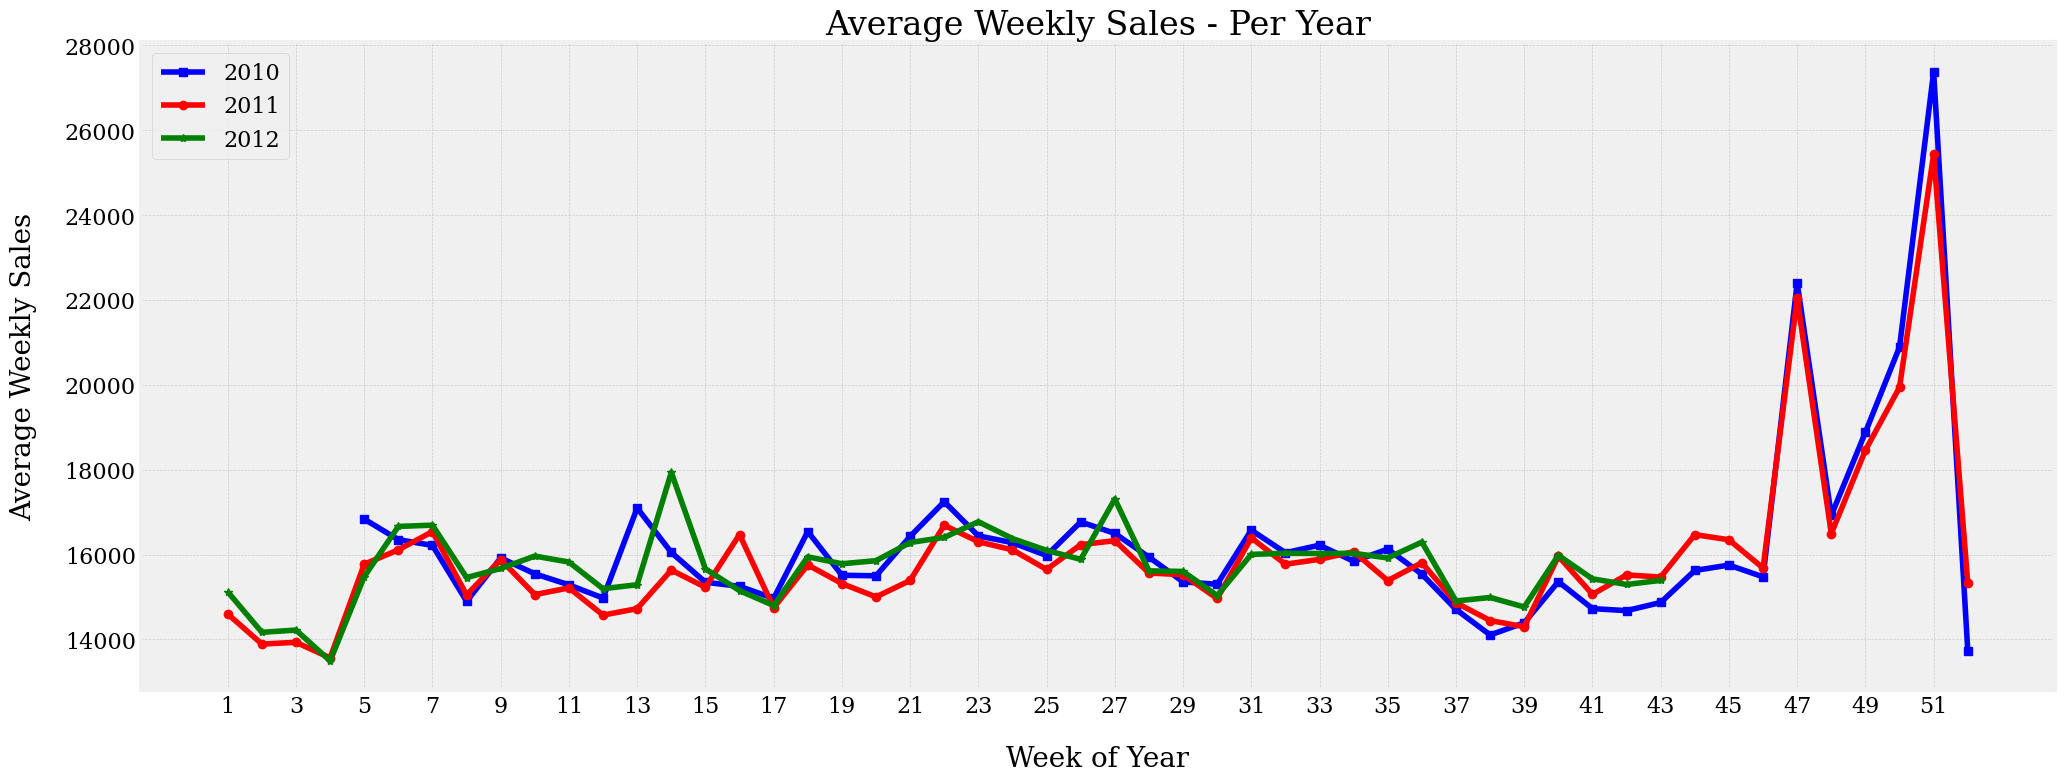

In [12]:

# Grouping the sales by WeekOfYear for each year
weekly_sales_2010 = merged[merged.Year == 2010].groupby('WeekOfYear')['Weekly_Sales'].mean()
weekly_sales_2011 = merged[merged.Year == 2011].groupby('WeekOfYear')['Weekly_Sales'].mean()
weekly_sales_2012 = merged[merged.Year == 2012].groupby('WeekOfYear')['Weekly_Sales'].mean()

# Create the plot
plt.figure(figsize=(22,8))

# Plotting each year with distinct markers and line styles
plt.plot(weekly_sales_2010.index, weekly_sales_2010.values, 's-', color='b', label='2010')  # Square marker for 2010
plt.plot(weekly_sales_2011.index, weekly_sales_2011.values, 'o-', color='r', label='2011')  # Circle marker for 2011
plt.plot(weekly_sales_2012.index, weekly_sales_2012.values, '*-', color='g', label='2012')  # Star marker for 2012

# Customizing ticks
plt.xticks(np.arange(1, 53, step=2), fontsize=16)  # Show every other week for clarity
plt.yticks(fontsize=16)

# Adding labels and title
plt.xlabel('Week of Year', fontsize=20, labelpad=20)
plt.ylabel('Average Weekly Sales', fontsize=20, labelpad=20)
plt.title("Average Weekly Sales - Per Year", fontsize=24)

# Adding a legend with customized font size
plt.legend(fontsize=16)

# Show grid for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Display the plot
plt.show()


**Insights:**

On weekly basis the week of Thanksgiving holiday and one week before Christmas witnessed the highest sales for the years 2010 and 2011
In 2012 the week no. 14 recorded the highest sales as compared to other weeks of the year but that doesn't correponds to any holiday or any special event

## **Average Store Sales**

In [13]:
store_sales = merged.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False)


fig = px.bar(store_sales,
             x=store_sales.index,
             y=store_sales.values,
             title="Average Sales - Per Store",
             labels={'x':'Stores', 'y':'Sales'},
             color_discrete_sequence=["#DC143C"], template='plotly_white')

fig.update_xaxes(tick0=1, dtick=1)

fig.show()

**Insights:**

The sales vary by large amount among the 45 stores
It really depends which category of store it is and which week of the particular year is under consideration

## **Average Store Sales - Year Wise**

In [14]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Group data for 2010, 2011, and 2012
store_sales_2010 = merged[merged.Year == 2010].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2010_df = pd.DataFrame(list(store_sales_2010.items()), columns=['Store', 'AvgSales2010'])

store_sales_2011 = merged[merged.Year == 2011].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2011_df = pd.DataFrame(list(store_sales_2011.items()), columns=['Store', 'AvgSales2011'])

store_sales_2012 = merged[merged.Year == 2012].groupby('Store')['Weekly_Sales'].mean().to_dict()
store2012_df = pd.DataFrame(list(store_sales_2012.items()), columns=['Store', 'AvgSales2012'])

# Create subplots
fig = make_subplots(
    rows=3, cols=1, subplot_titles=("Average Store Sales 2010", "Average Store Sales 2011", "Average Store Sales 2012")
)

# Add bar charts for each year
fig.add_trace(go.Bar(
    x=store2010_df.Store, y=store2010_df.AvgSales2010,
    marker=dict(color='#FF6347'),  # Color for 2010
    name="2010"
), row=1, col=1)

fig.add_trace(go.Bar(
    x=store2011_df.Store, y=store2011_df.AvgSales2011,
    marker=dict(color='#4682B4'),  # Color for 2011
    name="2011"
), row=2, col=1)

fig.add_trace(go.Bar(
    x=store2012_df.Store, y=store2012_df.AvgSales2012,
    marker=dict(color='#32CD32'),  # Color for 2012
    name="2012"
), row=3, col=1)

# Update layout
fig.update_layout(
    coloraxis=dict(colorscale='Bluered_r'),  # Color scale for the bars
    template='plotly_dark',  # Dark theme
    showlegend=False,  # Disable legend
    height=1200,  # Increase height to avoid crowding
    title="Average Store Sales per Year (2010-2012)",  # Overall title
    margin=dict(l=50, r=50, t=100, b=150),  # Adjust margins
)

# Update x and y axis titles and formatting
fig.update_xaxes(title_text="Store", tickangle=45, row=1, col=1)
fig.update_xaxes(title_text="Store", tickangle=45, row=2, col=1)
fig.update_xaxes(title_text="Store", tickangle=45, row=3, col=1)

fig.update_yaxes(title_text="Avg Sales", row=1, col=1)
fig.update_yaxes(title_text="Avg Sales", row=2, col=1)
fig.update_yaxes(title_text="Avg Sales", row=3, col=1)

# Show the figure
fig.show()


**Insights:**

The overall trend of store sales over the 3 years remain the same as it depends on the type of store and its size

The stores 2,4,13,14 and 20 showed the highest sales in all the 3 years

## **Average Department Sales**

In [15]:
import plotly.express as px

# Group by department and calculate average weekly sales
dept_sales = merged.groupby('Dept')['Weekly_Sales'].mean().sort_values(ascending=False)

# Create the horizontal bar chart
fig = px.bar(dept_sales,
             x=dept_sales.values,
             y=dept_sales.index,
             template='plotly_dark',
             title="Average Sales - Per Department",
             labels={'x':'Dept', 'y':'Sales'},
             color_discrete_sequence=["#4682B4"],
             orientation='h',
             height=1200,
             width=1000)

# Update the y-axis tick positioning and format
fig.update_yaxes(tick0=1, dtick=1)

# Increase font size for title and axes for better readability
fig.update_layout(
    title={'font': {'size': 24}},  # Larger title
    xaxis_title={'font': {'size': 18}},
    yaxis_title={'font': {'size': 18}},
    showlegend=False,  # Hide legend as we have one color
)

# Optionally, adjust the x-axis gridlines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='gray')

# Show the plot
fig.show()


**Insights**:

Different departments showed different levels of average sales

Notables are 38,65,72,92 and 95 which have highest average sales

## **Average Department Sales - Per Year**

Let's check the department sales on yearly basis to see if there are some departments which have different levels of sales in 3 different years

In [16]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Data preparation for 2010, 2011, and 2012
dept_sales_2010 = merged[merged.Year == 2010].groupby('Dept')['Weekly_Sales'].mean().to_dict()
dept2010_df = pd.DataFrame(list(dept_sales_2010.items()), columns=['Dept', 'AvgSales2010'])

dept_sales_2011 = merged[merged.Year == 2011].groupby('Dept')['Weekly_Sales'].mean().to_dict()
dept2011_df = pd.DataFrame(list(dept_sales_2011.items()), columns=['Dept', 'AvgSales2011'])

dept_sales_2012 = merged[merged.Year == 2012].groupby('Dept')['Weekly_Sales'].mean().to_dict()
dept2012_df = pd.DataFrame(list(dept_sales_2012.items()), columns=['Dept', 'AvgSales2012'])

# Create subplots with 3 columns for the years 2010, 2011, and 2012
fig = make_subplots(rows=1, cols=3, subplot_titles=("Average Dept Sales 2010", "Average Dept Sales 2011", "Average Dept Sales 2012"))

# Add bar traces for each year with different color
fig.add_trace(go.Bar(x=dept2010_df.AvgSales2010, y=dept2010_df.Dept, orientation='h', name="2010", marker_color='#DC143C'), 1, 1)
fig.add_trace(go.Bar(x=dept2011_df.AvgSales2011, y=dept2011_df.Dept, orientation='h', name="2011", marker_color='#FF6347'), 1, 2)
fig.add_trace(go.Bar(x=dept2012_df.AvgSales2012, y=dept2012_df.Dept, orientation='h', name="2012", marker_color='#4682B4'), 1, 3)

# Update layout for overall styling and legend
fig.update_layout(
    template='plotly_dark',  # Use dark template
    showlegend=True,  # Show legend
    height=800,  # Adjust height for better spacing
    width=1200,  # Adjust width for better visibility
    title='Average Department Sales by Year',
    title_x=0.5,  # Center the title
    title_font={'size': 24},  # Larger title font size
)

# Update axis titles and font sizes for clarity
fig.update_xaxes(title_text="Avg Sales", row=1, col=1, title_font={'size': 18})
fig.update_xaxes(title_text="Avg Sales", row=1, col=2, title_font={'size': 18})
fig.update_xaxes(title_text="Avg Sales", row=1, col=3, title_font={'size': 18})

fig.update_yaxes(title_text="Department", row=1, col=1, title_font={'size': 18})
fig.update_yaxes(title_text="Department", row=1, col=2, title_font={'size': 18})
fig.update_yaxes(title_text="Department", row=1, col=3, title_font={'size': 18})

# Show the plot
fig.show()


Insights:

The sales trend on yearly basis remain the same. Stores with higher sales appeared in all the 3 years while with lowe sales showed the same trend in all the 3 years

## **Holidays Vs Nonholidays Sales**

In [17]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

holiday_sales = merged.groupby('IsHoliday')['Weekly_Sales'].mean()
holiday_counts = merged.IsHoliday.value_counts()

fig = make_subplots(rows=1, cols=2, subplot_titles=("Holidays/Nonholidays Sales", "Holidays/Nonholidays Counts"))

fig.add_trace(go.Bar(x=holiday_sales.values, y=holiday_sales.index, orientation='h',),1, 1)

fig.add_trace(go.Bar(x=holiday_counts.values, y=holiday_counts.index, orientation='h',),1, 2)

fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), template='plotly_dark', showlegend=False)
fig.show()

**Insights**:

Only 7 percent of the weeks in the data are the holiday weeks
Despite being the less peecentage of holiday weeks the sales in the holidays week are on the average higher than in the non-holiday weeks

## **Relationship: Week of Year vs Sales**

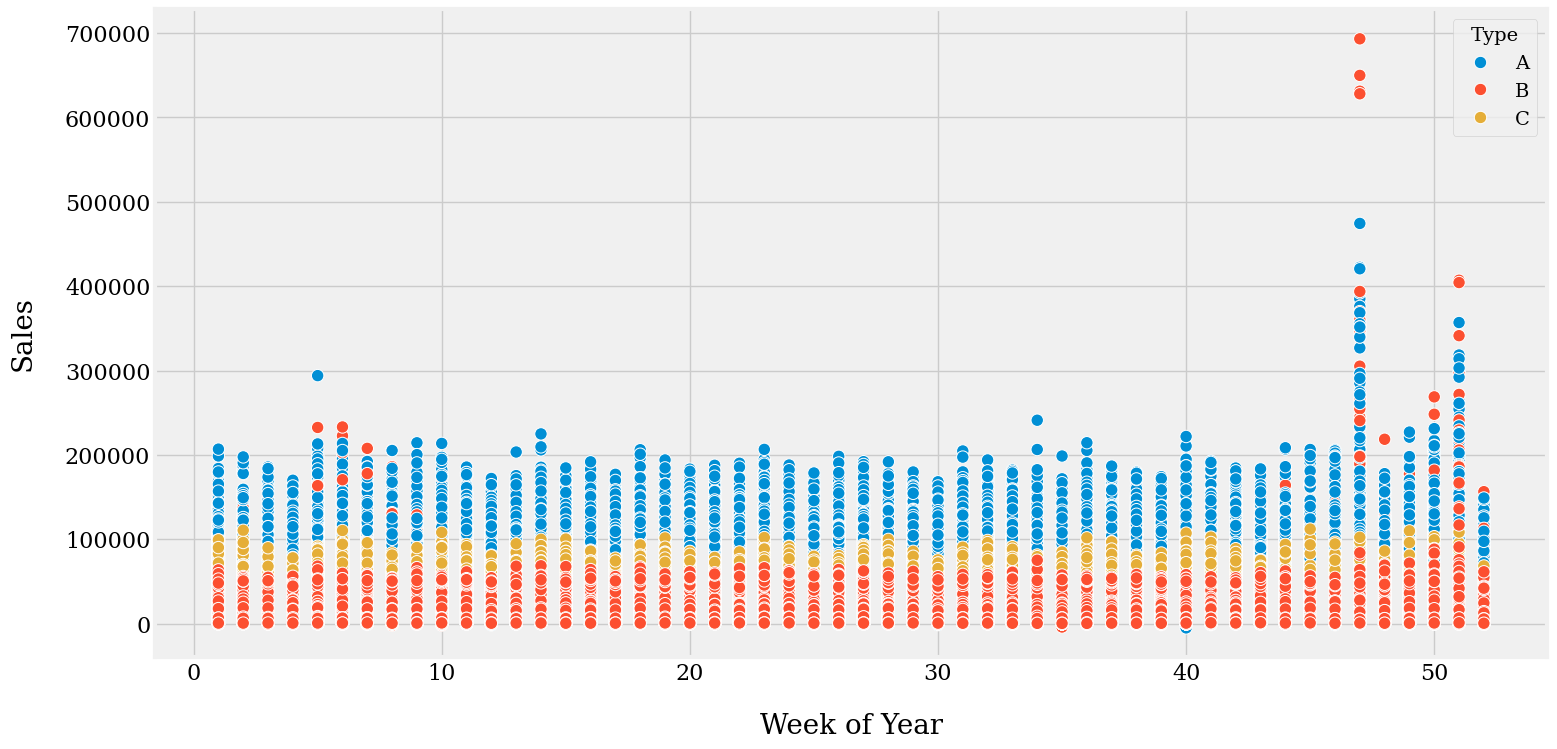

In [18]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=merged.WeekOfYear, y=merged.Weekly_Sales, hue=merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Week of Year', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

**Insights**:

This shows only a slight relationship as the weekly sales increased towards the end of the year

## **Relationship: Size of Store vs Sales**

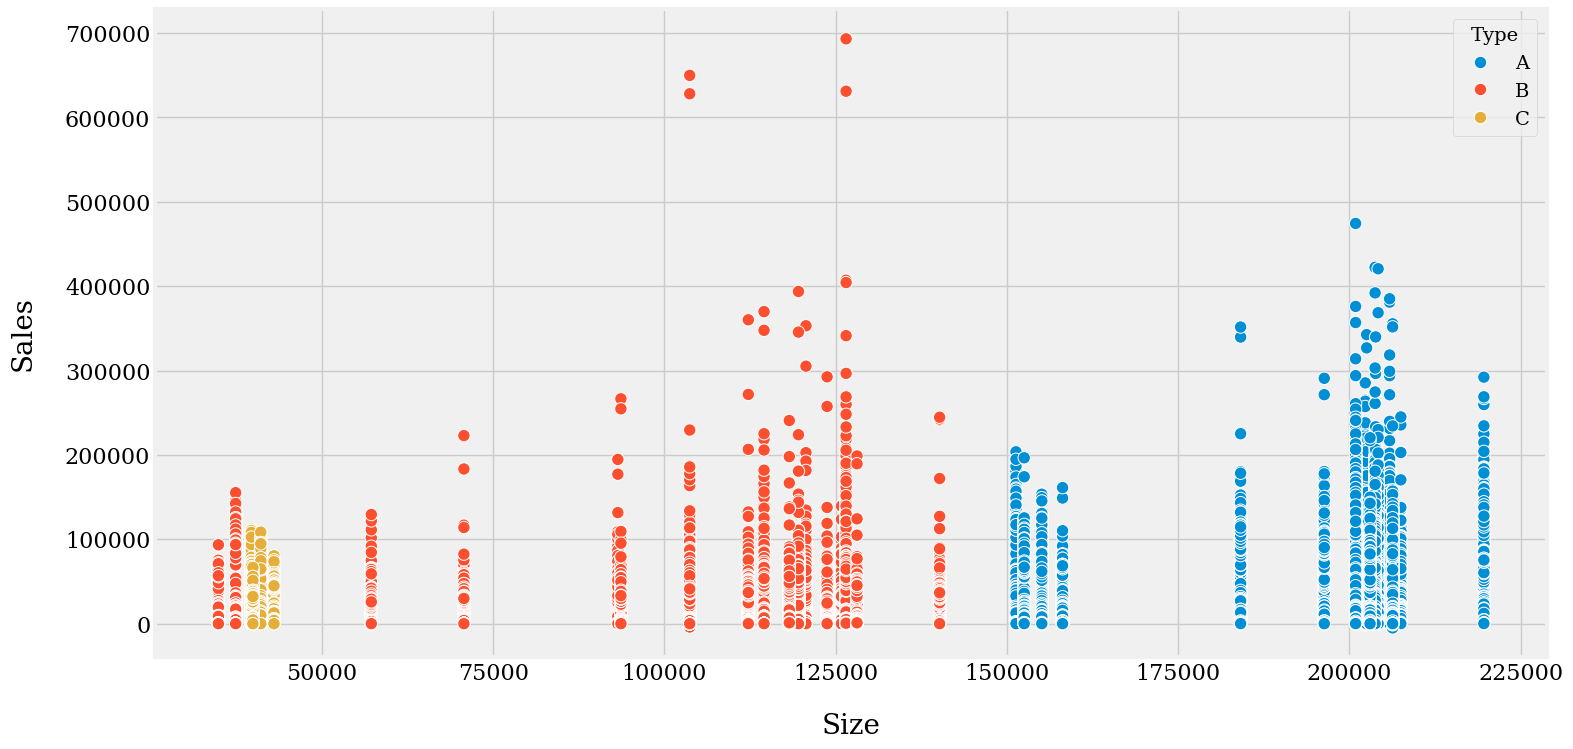

In [19]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=merged.Size, y=merged.Weekly_Sales, hue=merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Size', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

**Insights**:

The size of the store shows a linear relationship with the weekly sales. The sales generally increases with increase of size of store with some exceptions

## **Relationship: Temperature vs Sales**

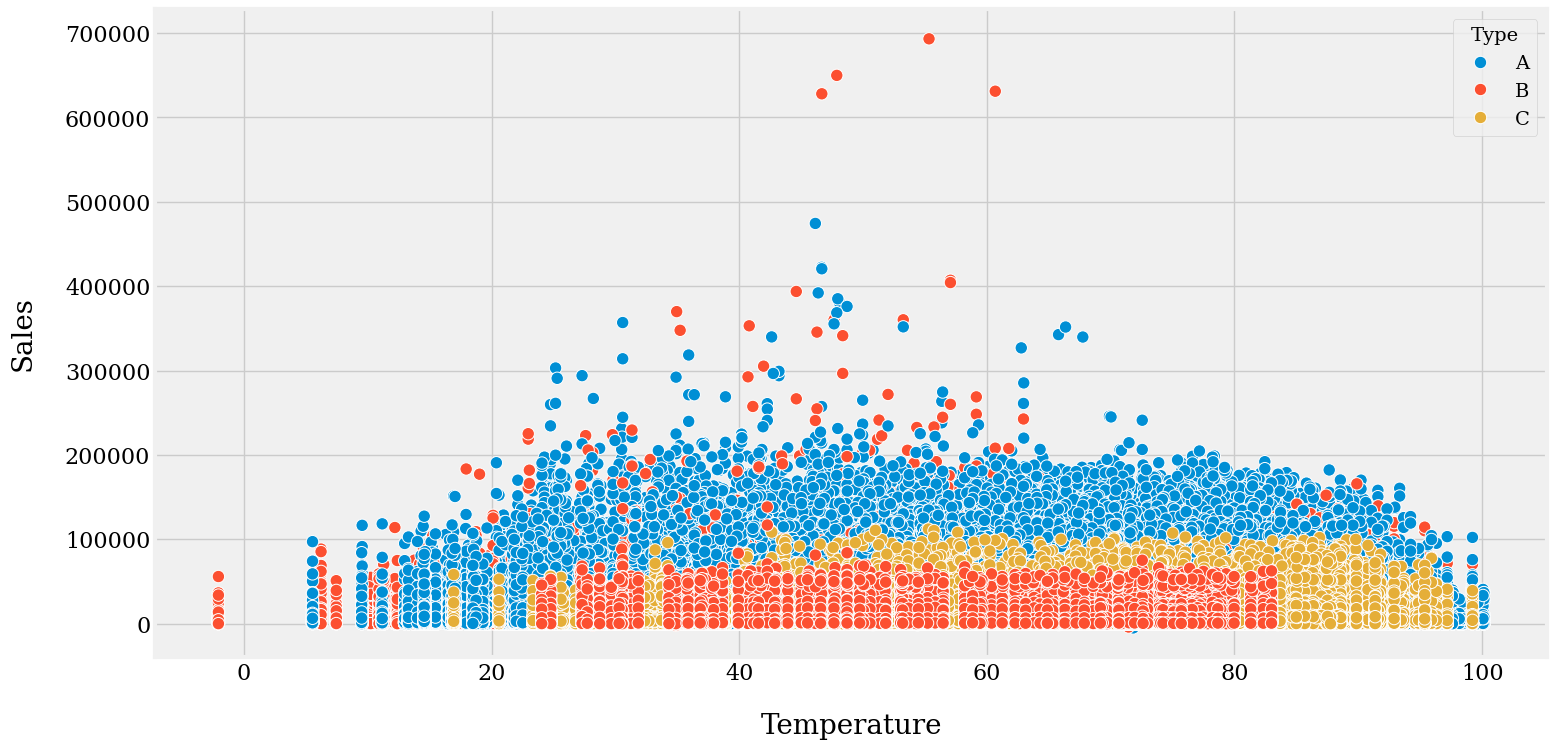

In [20]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=merged.Temperature, y=merged.Weekly_Sales, hue=merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Temperature', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

**Insights**:

There seems to be no relatiobship between the temperature in the region and weekly sales of the stores. At low and very high temperatures the sales seems to dip a bit but in general there doesn't exist a clear relationship

## **Relationship: Fuel Price vs Sales**

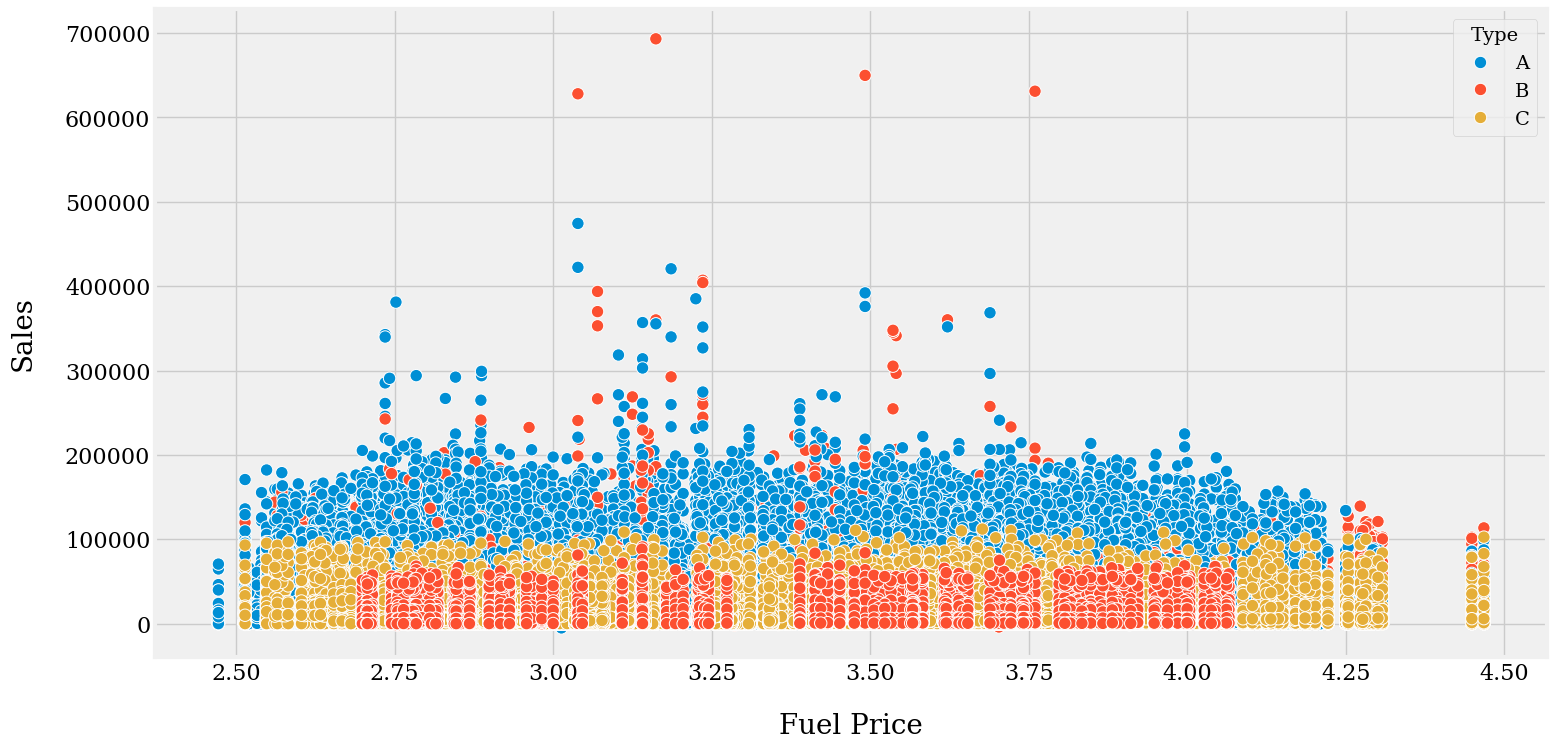

In [21]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=merged.Fuel_Price, y=merged.Weekly_Sales, hue=merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Fuel Price', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

**Insights**:

Between fuel price and the sales there doesn't seem to exist any clear relationship

## **Relationship: CPI vs Sales**

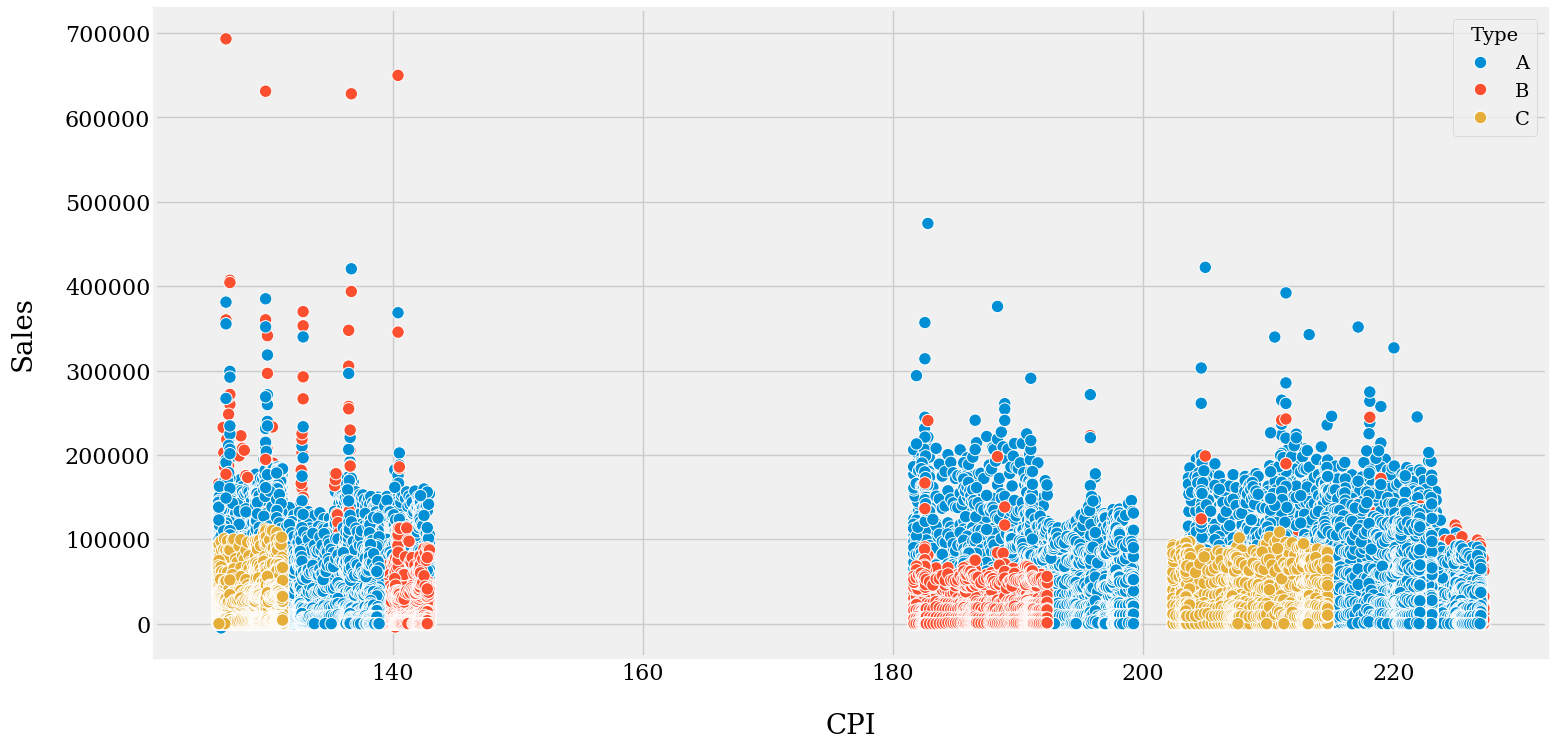

In [22]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=merged.CPI, y=merged.Weekly_Sales, hue=merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('CPI', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

**Insights**:

There are 3 clear clusters but there doesn't exist any clear correlation between CPI and weekly sales

## **Relationship: Unemployment vs Sales**

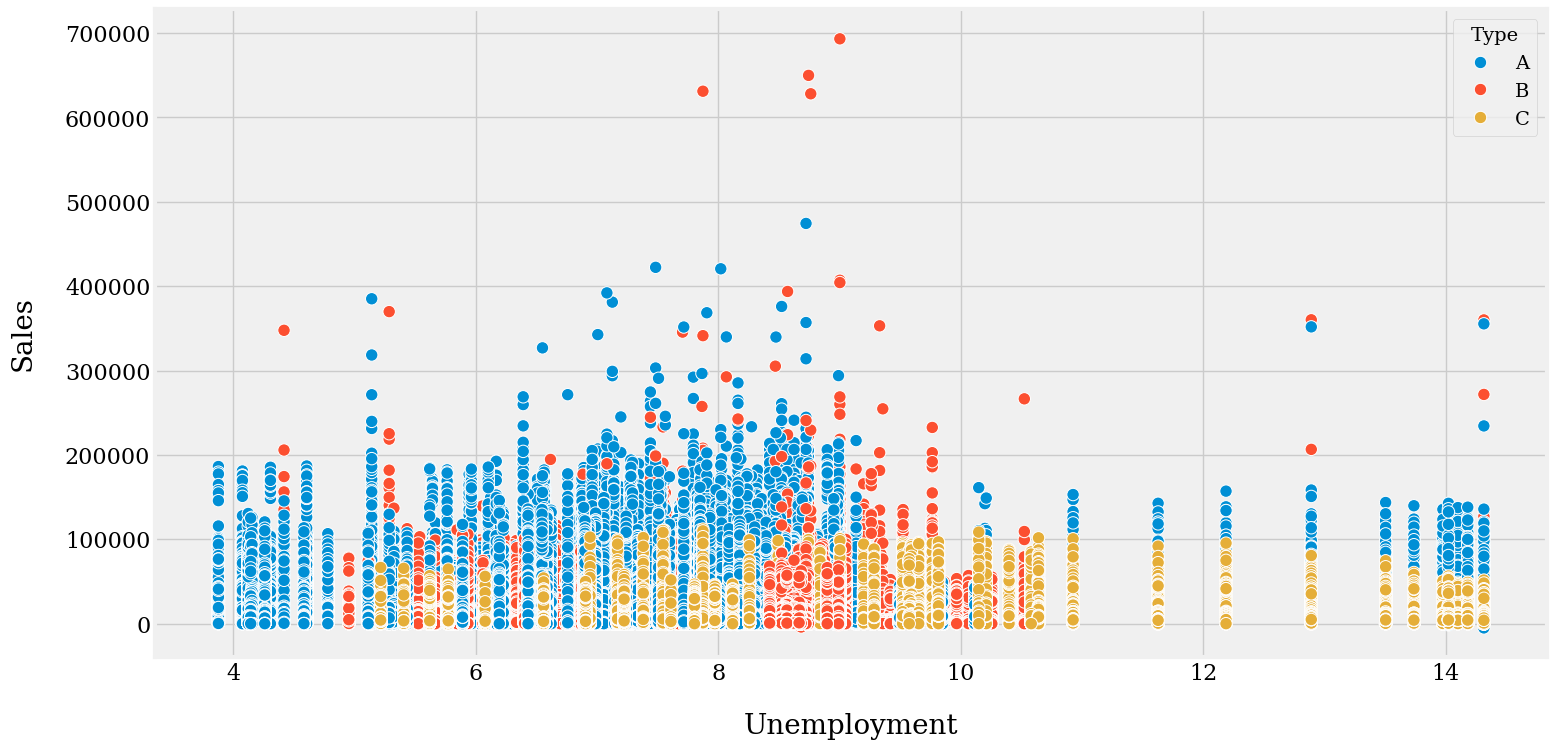

In [23]:
plt.figure(figsize=(16,8))
sns.scatterplot(x=merged.Unemployment, y=merged.Weekly_Sales, hue=merged.Type, s=80);

plt.xticks( fontsize=16)
plt.yticks( fontsize=16)
plt.xlabel('Unemployment', fontsize=20, labelpad=20)
plt.ylabel('Sales', fontsize=20, labelpad=20);

**Insights**:

Also the Unemployment rate doesn't seem to have any effect on the weekly sales

## **Coorelation Matrix**

Lets study the relationship between the different columns numerically to check how they correlate with the weekly sales in order to confirm the inferences we have gathered from the above EDA study. Since the correlation value can only be calculated for the numerical columns, so we will first convert the 'Type' column to numerical values. Type 'A', 'B' and 'C' will be mapped to 1, 2 and 3 respectively

In [27]:
storetype_values = {'A':3, 'B':2, 'C':1}
merged['Type_Numeric'] = merged.Type.map(storetype_values)
testing_merged['Type_Numeric'] = testing_merged.Type.map(storetype_values)

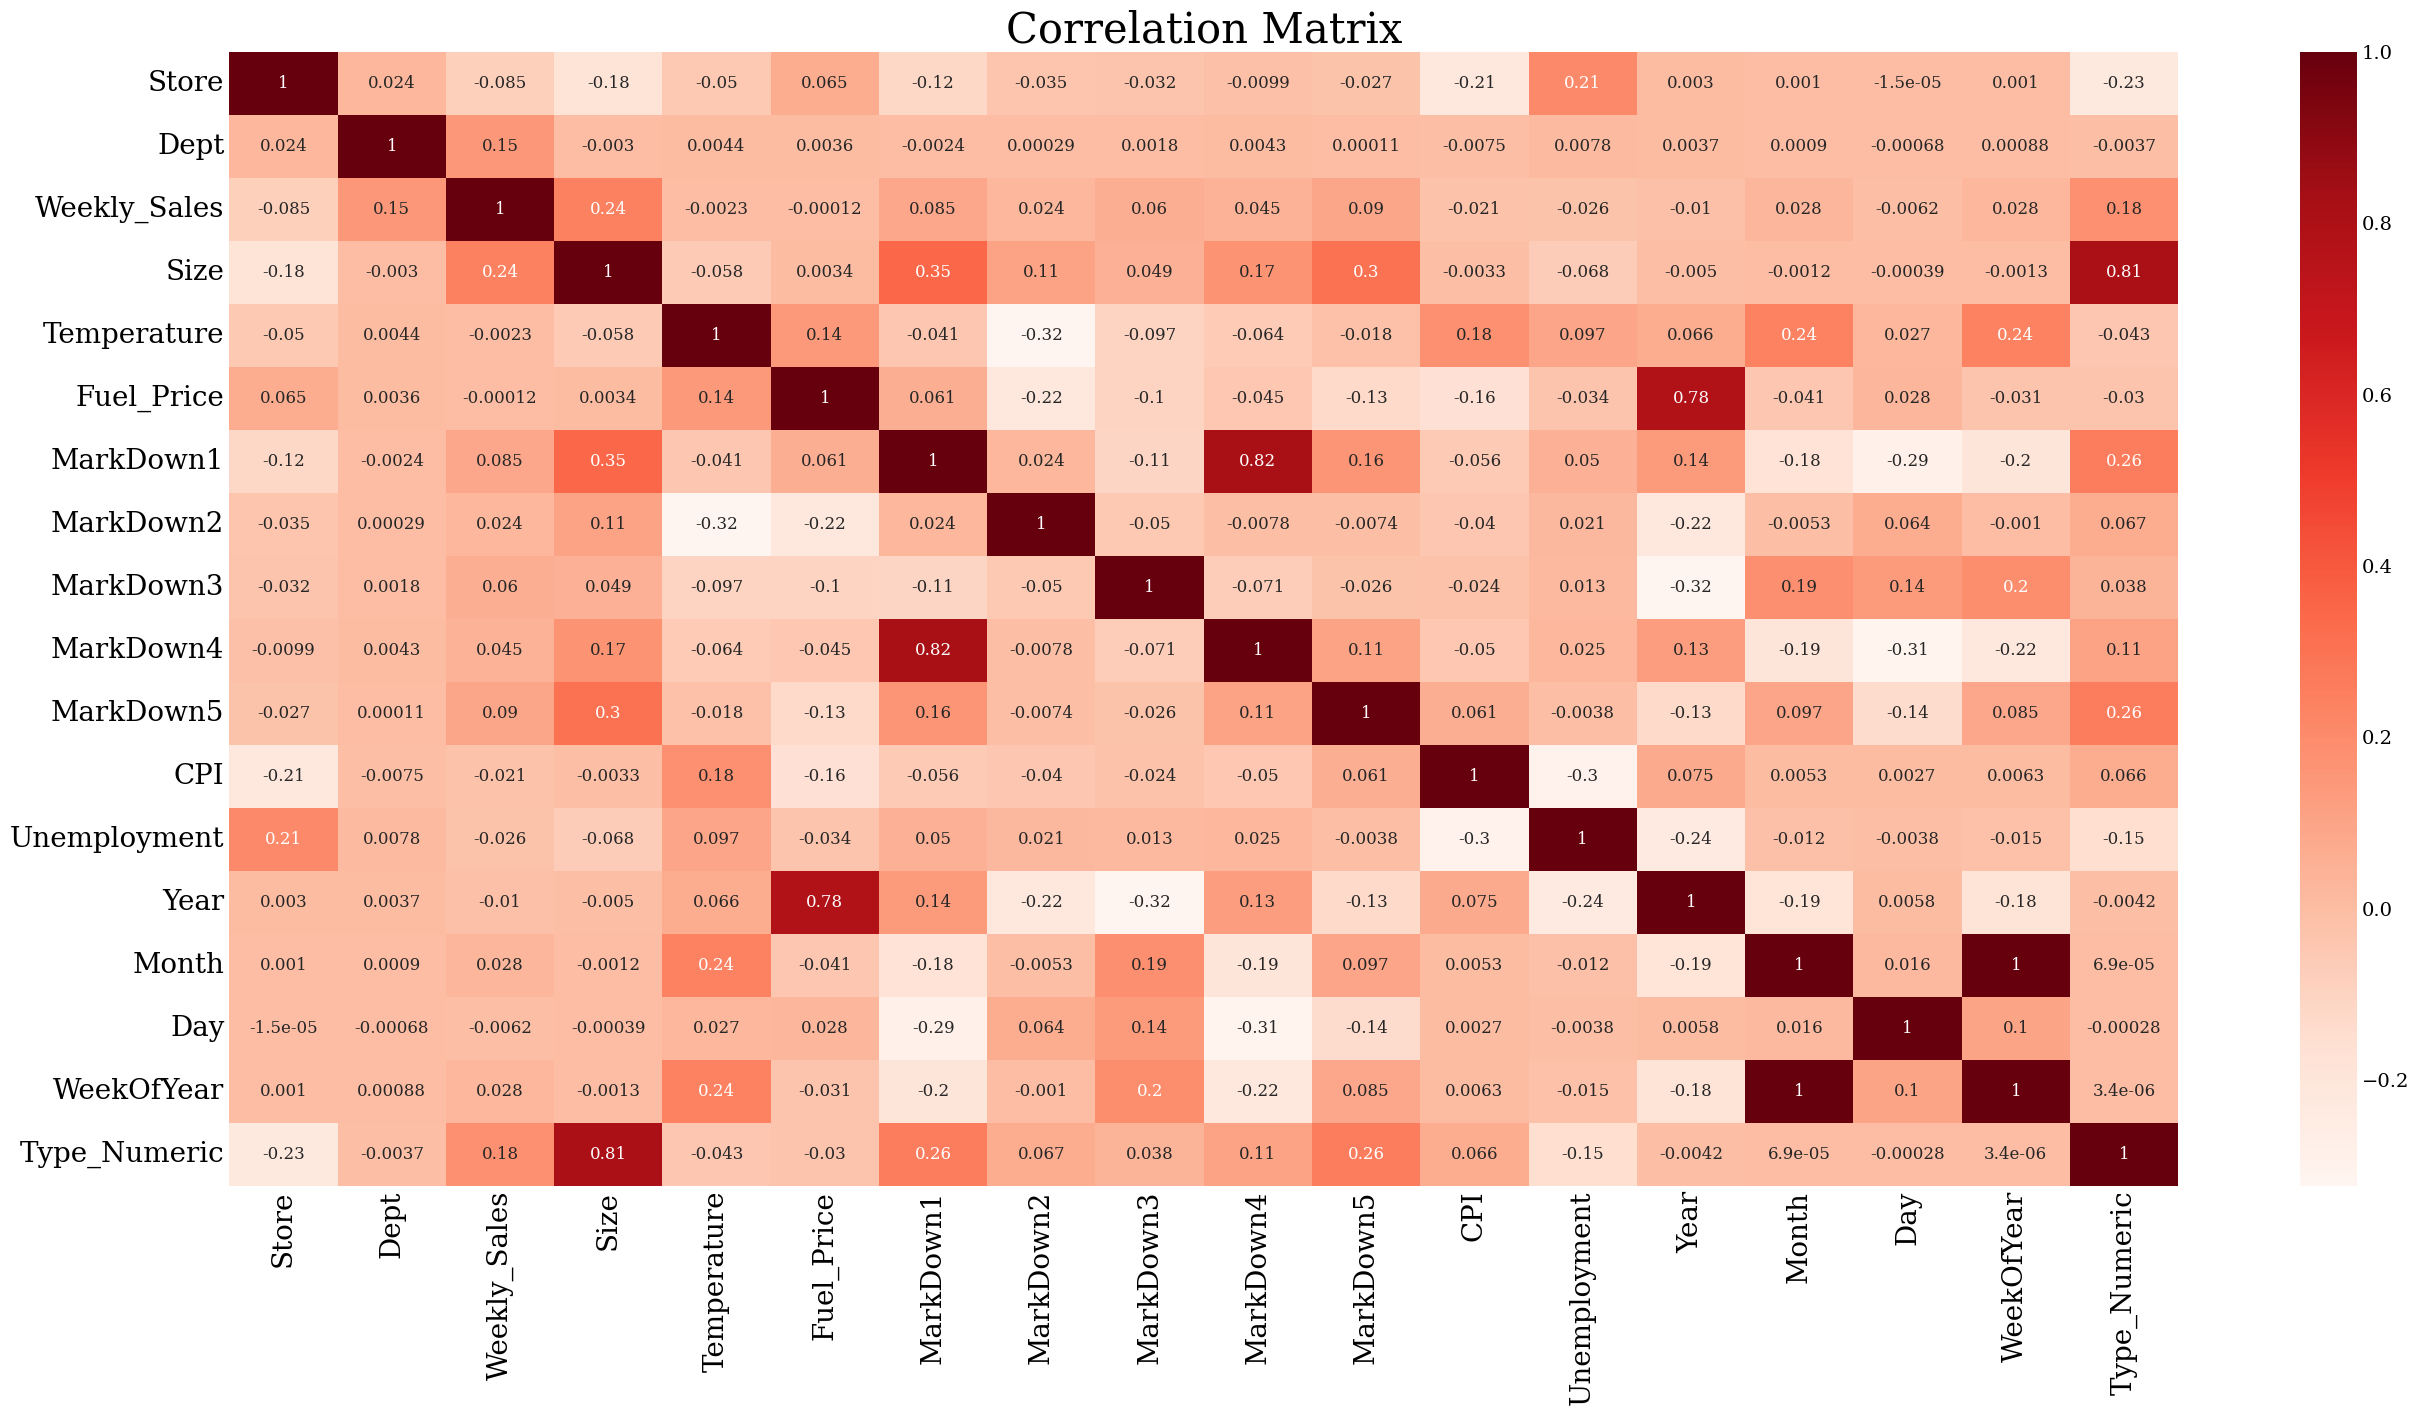

In [28]:
# Filter out only numeric columns
numeric_cols = merged.select_dtypes(include=[np.number]).columns
correlation_matrix = merged[numeric_cols].corr()

# Plot the heatmap
plt.figure(figsize=(28,14))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.heatmap(correlation_matrix, cmap='Reds', annot=True, annot_kws={'size':12})
plt.title('Correlation Matrix', fontsize=30)
plt.show()

**Insights**:

Department, Store size and Type have moderate correlation with the weekly sales
Markdown1-5 have very weak correlation with the weekly sales, so we will leave these columns out
Temperature. Fuel price, CPI and Unemployment are very weakly coorelated with the weekly sales, so these columns will also be dropped out
IsHoliday will be considered for the further analysis as the sales in the holiday weeks are higher than in the non-holiday weeks
We will also leave out Month and Day as this information is already contained in the WeekOfYear

## **3. Data Preparation for Model Training**

Following steps will be performed for preparing the data for the subsequent model training

Based on the Exploratory Data Analysis and Coorelation study, the columns with weak relationship with the target column will be dropped
Input and Target dataframes will be created
Inputs will be scaled in the 0 to 1 range
Training and Validation datasets will be created
A function will be defined based on which the models performance will be measured

In [29]:
merged = merged.drop(['Date', 'Temperature','Fuel_Price', 'Type', 'MarkDown1', 'MarkDown2', 'MarkDown3',
                      'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Month', 'Day'], axis=1, errors='ignore')

testing_merged = testing_merged.drop(['Date', 'Temperature','Fuel_Price', 'Type', 'MarkDown1', 'MarkDown2', 'MarkDown3',
                                      'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Month', 'Day'], axis=1, errors='ignore')


In [30]:
# Identify input and target columns

input_cols = merged.columns.to_list()
input_cols.remove('Weekly_Sales')
target_col = 'Weekly_Sales'

inputs_df = merged[input_cols].copy()
targets = merged[target_col].copy()

In [31]:
# Create training and validation sets

from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df, targets, test_size=0.3, random_state=42)

In [32]:
# Define the function to evaluate the models

def WMAE(df, targets, predictions):
    weights = df.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(targets-predictions))/(np.sum(weights)), 2)

## **4. Machine Learning**

**Following ML models will be tested in this analysis:**

Linear Regression\
Decision Tree\
Random Forest

## **Linear Regression**

In [33]:
!pip install scikit-learn --quiet

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Create and train the model
model = LinearRegression().fit(train_inputs, train_targets)

# Generate predictions on training data
train_preds = model.predict(train_inputs)

# Compute WMAE on traing data
train_wmae = WMAE(train_inputs, train_targets, train_preds)
print('The WMAE loss for the training set is  {}.'.format(train_wmae))

# Generate predictions on validation data
val_preds = model.predict(val_inputs)

# Compute WMAE on validation data
val_wmae = WMAE(val_inputs, val_targets, val_preds)
print('The WMAE loss for the validation set is  {}.'.format(val_wmae))

# Generate predictions on validation data
val_preds = model.predict(val_inputs)

# Calculate regression metrics
mae = mean_absolute_error(val_targets, val_preds)
mse = mean_squared_error(val_targets, val_preds)
rmse = np.sqrt(mse)  # or use mean_squared_error(val_targets, val_preds, squared=False)
r2 = r2_score(val_targets, val_preds)

# Print the metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")

The WMAE loss for the training set is  14776.36.
The WMAE loss for the validation set is  14884.37.
MAE: 14576.645430188919
MSE: 475155405.50674033
RMSE: 21798.059672978703
R-squared: 0.08569433856911102


## **Decision Tree**

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()

tree.fit(train_inputs, train_targets)

tree_train_preds = tree.predict(train_inputs)

# Compute WMAE on traing data
tree_train_wmae = WMAE(train_inputs, train_targets, tree_train_preds)
print('The WMAE loss for the training set is  {}.'.format(tree_train_wmae))


# Compute WMAE on validation data
tree_val_preds = tree.predict(val_inputs)
tree_val_wmae = WMAE(val_inputs, val_targets, tree_val_preds)
print('The WMAE loss for the validation set is  {}.'.format(tree_val_wmae))

The WMAE loss for the training set is  0.0.
The WMAE loss for the validation set is  1942.89.


In [44]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create and train the DecisionTreeRegressor model
tree = DecisionTreeRegressor()
tree.fit(train_inputs, train_targets)

# Make predictions on training and validation sets
train_preds = tree.predict(train_inputs)
val_preds = tree.predict(val_inputs)

# Evaluate regression metrics on the training set
print('Training Mean Absolute Error: {:.2f}'.format(mean_absolute_error(train_targets, train_preds)))
print('Training Mean Squared Error: {:.2f}'.format(mean_squared_error(train_targets, train_preds)))
print('Training R-squared: {:.2f}'.format(r2_score(train_targets, train_preds)))

# Evaluate regression metrics on the validation set
print('Validation Mean Absolute Error: {:.2f}'.format(mean_absolute_error(val_targets, val_preds)))
print('Validation Mean Squared Error: {:.2f}'.format(mean_squared_error(val_targets, val_preds)))
print('Validation R-squared: {:.2f}'.format(r2_score(val_targets, val_preds)))


Training Mean Absolute Error: 0.00
Training Mean Squared Error: 0.00
Training R-squared: 1.00
Validation Mean Absolute Error: 1722.37
Validation Mean Squared Error: 24803215.97
Validation R-squared: 0.95


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Compute WMAE on training data
tree_train_wmae = WMAE(train_inputs, train_targets, tree_train_preds)
print('The WMAE loss for the training set is  {}.'.format(tree_train_wmae))

# Compute WMAE on validation data
tree_val_wmae = WMAE(val_inputs, val_targets, tree_val_preds)
print('The WMAE loss for the validation set is  {}.'.format(tree_val_wmae))

# Compute other regression metrics
print('Training Mean Absolute Error: {:.2f}'.format(mean_absolute_error(train_targets, tree_train_preds)))
print('Training Mean Squared Error: {:.2f}'.format(mean_squared_error(train_targets, tree_train_preds)))
print('Training R-squared: {:.2f}'.format(r2_score(train_targets, tree_train_preds)))

print('Validation Mean Absolute Error: {:.2f}'.format(mean_absolute_error(val_targets, tree_val_preds)))
print('Validation Mean Squared Error: {:.2f}'.format(mean_squared_error(val_targets, tree_val_preds)))
print('Validation R-squared: {:.2f}'.format(r2_score(val_targets, tree_val_preds)))


The WMAE loss for the training set is  0.0.
The WMAE loss for the validation set is  1942.89.
Training Mean Absolute Error: 0.00
Training Mean Squared Error: 0.00
Training R-squared: 1.00
Validation Mean Absolute Error: 1723.13
Validation Mean Squared Error: 24507963.30
Validation R-squared: 0.95


## **Gradient Boosting Machine**

In [40]:
!pip install xgboost lightgbm --upgrade --quiet

In [42]:
from xgboost import XGBRegressor

# Create the model
gbm = XGBRegressor(random_state=42, n_jobs=-1)

# Fit the model
gbm.fit(train_inputs, train_targets)

gbm_train_preds = gbm.predict(train_inputs)

# Compute WMAE on traing data
gbm_train_wmae = WMAE(train_inputs, train_targets, gbm_train_preds)
print('The WMAE loss for the training set is  {}.'.format(gbm_train_wmae))

gbm_val_preds = gbm.predict(val_inputs)

# Compute WMAE on validation data
gbm_val_wmae = WMAE(val_inputs, val_targets, gbm_val_preds)
print('The WMAE loss for the validation set is  {}.'.format(gbm_val_wmae))

The WMAE loss for the training set is  3059.97.
The WMAE loss for the validation set is  3157.3.


**Insights**:

For the Random Forest also, the Department, Store Size and Store Number have higher model importances than the other parameters

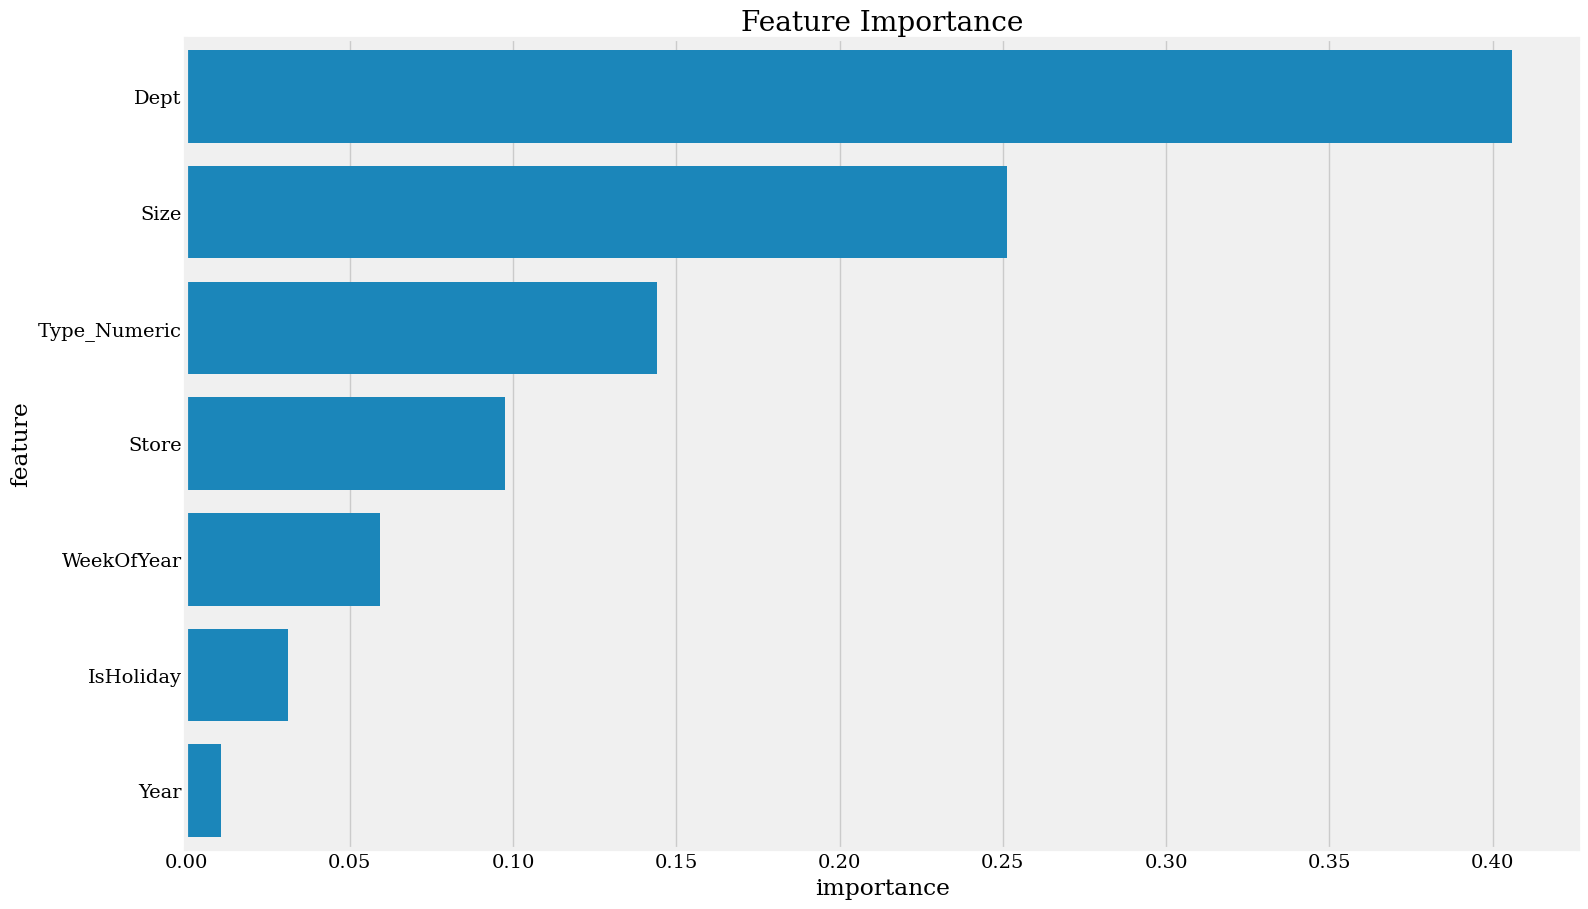

In [43]:
importance_df = pd.DataFrame({
    'feature': train_inputs.columns,
    'importance': gbm.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(16,10))
plt.title('Feature Importance')
sns.barplot(data=importance_df, x='importance', y='feature');

**Insights**:

For the Gradient Boosting Machine, the Department, Store Size and Store Type are the major contributing features

This differs little bit from Decision Trees and Random Forests as in this case the Store Type has higher importance than the Store Number

# **Model's Comparison**

**Linear Regression**

WMAE for Training set: 14776.36
WMAE for Validation set: 14884.37

**Decision Tree**

WMAE for Training set: 0.0
WMAE for Validation set: 1938.54

**Gradient Boosting Machine**

WMAE for Training set: 16.66
WMAE for Validation set: 1339.29

The best performer among the tested models is **'Gradient Boosting Machine'** with tuned Hyperparameters ¶

## **Making Predictions**

In [ ]:
test_preds = gbm.predict(testing_merged)
testing_merged['Weekly_Sales'] = test_preds

**Following inferences and conclusions can be drawn from the the analysis of the data:**

1. Type 'A' stores are more popular than 'B' and 'C' types Type 'A' stores outclass the 'B' and 'C' types in terms of size and the avergae weekly sales

2. Weekly Sales are effected by the week of year. Holiday weeks witnessed more sales than the non-holiday weeks. Notables are Thanksgiving and Christmas weeks

3. Size of the store is a major contributing factor in the weekly sales

4. Sales are also dependent on the department of the store as different departments showed different levels of weekly sales

5. Among the trained models for predicting the future sales, Grdient Boosting Machine with tuned hyperparameters performs the best